### **<span style="text-decoration: underline double; color:DarkBlue"> Trabajo CDR's de Milán </span>**

En este trabajo se busca realizar el **<span style="background-color:LightSkyBlue">tratamiento de datos procedentes de los registros de *"Call Detail Record"*</span>** de las operadoras de telecomunicaciones de Milán utilizando MongoDB.

En concreto, se analizan los datos de la semana 22/12/2013 - 28/12/2013:
1. sms-call-internet-mi-2013-12-22.txt (Lunes)
2. sms-call-internet-mi-2013-12-23.txt
3. sms-call-internet-mi-2013-12-24.txt
4. sms-call-internet-mi-2013-12-25.txt
5. sms-call-internet-mi-2013-12-26.txt
6. sms-call-internet-mi-2013-12-27.txt
7. sms-call-internet-mi-2013-12-28.txt 

---


### **<span style="color:DarkBlue"><u>EJERCICIO 1 </u></span>**


#### **<span style="color:DarkBlue"><u>1. Cargamos los datos:</u></span>**
##### **<span style="color:DarkBlue">1.1 Importamos las bibliotecas necesarias para esta sección:</span>**

In [1]:
import pandas as pd
import pymongo
import sys
import os
import numpy as np
from pprint import pprint
from math import nan
import matplotlib.pyplot as plt

##### **<span style="color:DarkBlue">1.2 Definimos la función que establecerá la conexión a Mongo:</span>**

In [2]:
def conexion_mongo(uri):

    try:
        client = pymongo.MongoClient(uri, serverSelectionTimeoutMS=5000)
        client.admin.command('ping') # Compruebo si hago conexión.
        print('✅ Conexión a MongoDB establecida.')
        return client
    except pymongo.errors.ConnectionFailure:
        print('❌ Error: no se ha podido establecer la conexión.')
        sys.exit()
    except Exception as e:
        print(f"❌ Error de autenticación o de otro tipo: {e}")
        print("Asegúrate de que el usuario y contraseña son correctos.")
        sys.exit()

##### **<span style="color:DarkBlue">1.3 Definimos la función que cargará los datos</span>**
En esta función podemos observar que cada archivo se carga por chunks y no "de golpe". Esto es así debido a que, al cargar los archivos "de golpe", la memoria WSL se sobrecargaba y se caía la conexión. Al cargarlos por chunks o batches, el problema se soluciona. Además, he atribuido "labels" a los datos, puesto que los ficheros .txt no tenían esa info.

Por otro lado, sabemos que hay campos dentro de los ficheros en los que hay *missing values*. El tratamiento que he decidido aplicar ha sido **introducir 0** en dichos *missing values*.


In [3]:
def loader(client, nombre_db, nombre_colec, data_dir, headers):

    db = client[nombre_db]
    coleccion = db[nombre_colec]

    # ... (el código de borrar la colección no cambia) ...
    try:
        print(f'⚠️ Limpiando la colección {nombre_colec} antes de la carga...')
        resultado_borrado = coleccion.delete_many({})
        print(f'✅ Colección limpiada. {resultado_borrado.deleted_count} documentos borrados.')
    except Exception as e:
        print(f'❌ Error al limpiar la colección: {e}')
        sys.exit()
    
    num_files = 0
    for file in os.listdir(data_dir):
        file_path = os.path.join(data_dir, file) 
        
        print(f'💼 Procesando archivo: {file}...')

        chunk_num = 1
        total_rows_inserted = 0

        df_iterator = pd.read_csv(file_path, 
                                  sep=r'\s+', 
                                  header=None, 
                                  names=headers, 
                                  engine='python', 
                                  chunksize=100000 
                                 )
        
        # 
        
        for chunk in df_iterator:

            chunk.fillna(0, inplace=True)
            records = chunk.to_dict(orient='records')
            
            try:
                result = coleccion.insert_many(records)
                total_rows_inserted += len(result.inserted_ids)
                chunk_num += 1
            except Exception as e:
                print(f'❌ Error al insertar el lote {chunk_num}: {e}')
        
        print(f'✅ Archivo {file} completado. Total de filas insertadas: {total_rows_inserted}')
        num_files += 1

    print(f' ✅ Se han procesado {num_files} archivos en total.')

##### **<span style="color:DarkBlue">1.4 Lanzamos las funciones:</span>**

In [4]:
# Variables Globales
URI_MONGO = '<tu_URI>'
NOMBRE_DB = 'Milan_CDR_db'
NOMBRE_COLEC = 'Milan_CDR_c'
DATA_DIR = './Datos'
HEADERS = ['cellid', 'time', 'countrycode', 'smsin',
            'smsout', 'callin', 'callout', 'internet']

In [5]:
# Conectamos con el cliente:
client = conexion_mongo(URI_MONGO)

✅ Conexión a MongoDB establecida.


In [6]:
# Cargamos los datos:
loader(client, NOMBRE_DB, NOMBRE_COLEC, DATA_DIR, HEADERS)

⚠️ Limpiando la colección Milan_CDR_c antes de la carga...
✅ Colección limpiada. 6849370 documentos borrados.
💼 Procesando archivo: sms-call-internet-mi-2013-12-26.txt...
✅ Archivo sms-call-internet-mi-2013-12-26.txt completado. Total de filas insertadas: 4162680
💼 Procesando archivo: sms-call-internet-mi-2013-12-27.txt...
✅ Archivo sms-call-internet-mi-2013-12-27.txt completado. Total de filas insertadas: 4547803
💼 Procesando archivo: sms-call-internet-mi-2013-12-22.txt...
✅ Archivo sms-call-internet-mi-2013-12-22.txt completado. Total de filas insertadas: 4482939
💼 Procesando archivo: sms-call-internet-mi-2013-12-25.txt...
✅ Archivo sms-call-internet-mi-2013-12-25.txt completado. Total de filas insertadas: 4907775
💼 Procesando archivo: sms-call-internet-mi-2013-12-23.txt...
✅ Archivo sms-call-internet-mi-2013-12-23.txt completado. Total de filas insertadas: 4986627
💼 Procesando archivo: sms-call-internet-mi-2013-12-24.txt...
✅ Archivo sms-call-internet-mi-2013-12-24.txt completado. T

---

### **<span style="color:DarkBlue"><u>EJERCICIOS 2 - 8 </u></span>**


#### **<span style="color:DarkBlue"><u>2. Analizamos los datos</u></span>**

A continuación pasamos a analizar los datos cargados en la sección anterior. Los objetivos marcados por la práctica son:

- Encuentra los países con los que se interactúa.

- Encuentra que país es con el que más se interactúa ademas de Italia.

- ¿Qué celda comunica más con el extranjero?

- Encuentra la celda con más actividad de smsin, smsout callin, callout, internet y la total.

- Crea una colección con una documento por celda en el que aparezcan los acumulados de los
diferentes campos.

- Crea una colección con una documento por celda y hora en el que aparezcan los acumulados de los diferentes campos.

- Realiza un estudio de las celdas 4259 (Bocconi), 4456 (Navigli), 5060 (Duomo), 1419 (terreno agricula), 2436 (área industrial), 4990 (aeropuerto de Linate), 945 (residencial aislado) y 5048 (residencial céntrico)

Para ello, en primer lugar, cargamos los datos.



In [7]:
# Cargamos la base de datos y la colección
db = client[NOMBRE_DB]  # También podemos client.NOMBRE_DB
coleccion = db[NOMBRE_COLEC] # También db.NOMBRE_COLEC

##### **<span style='color:DarkBlue'>2.1 Encontrar los países con los que se interactúa</span>**
Para encontrar los países con los que se interactúa, pasamos a extraer los datos únicos asociados al campo **countrycode**. 

Esto podemos conseguirlo de dos formas diferentes:

- **Forma 1:** hacemos uso del comando `coleccion.distinct(filtro)`, el cual devuelve una lista de Python con los valores únicos asociados a un campo. (Más intuitivo)
- **Forma 2:** hacemos uso del comando `coleccion.aggregate(pipeline)`, el cual nos permitirá concatenar una serie de órdenes para realizar dicho cálculo. (Menos intuitivo)

<!-- Antes de determinar estos países debemos hacer un estudio de los datos para saber si **faltan datos**. Debemos saber que los datos vacíos se guardan como **nan**, por lo que haremos uso de 
`math.nan` para extraerlos: -->

Concluimos con que NO hay documentos en los que haya *missing values* en el campo "countrycode". Pasamos a determinar los countrycodes con los dos métodos mencionados:

In [8]:
# --------------------- Forma 1 --------------------- #
codes = coleccion.distinct('countrycode')
num_codes = len(codes)
print(f' Hay un total de {num_codes} countrycodes con los que se interacciona.\n', 
      'Los códigos son:\n')
num_code_per_line = 13
for i in range(1,int(np.ceil(num_codes/num_code_per_line))):
      inicio = (i-1)*num_code_per_line
      final = i*num_code_per_line
      print(codes[inicio:final])

 Hay un total de 299 countrycodes con los que se interacciona.
 Los códigos son:

[0, 1, 7, 20, 27, 30, 31, 32, 33, 34, 36, 39, 40]
[41, 43, 44, 45, 46, 47, 48, 49, 51, 52, 53, 54, 55]
[56, 57, 58, 60, 61, 62, 63, 64, 65, 66, 81, 82, 84]
[86, 90, 91, 92, 93, 94, 95, 98, 211, 212, 213, 216, 218]
[220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232]
[233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245]
[247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258, 260]
[261, 262, 263, 264, 265, 267, 291, 297, 298, 299, 350, 351, 352]
[353, 354, 355, 356, 357, 358, 359, 370, 371, 372, 373, 374, 375]
[376, 377, 378, 380, 381, 382, 385, 386, 387, 389, 420, 421, 423]
[500, 501, 502, 503, 504, 505, 506, 507, 508, 509, 590, 591, 592]
[593, 594, 595, 596, 597, 598, 599, 670, 672, 673, 675, 676, 677]
[678, 679, 680, 681, 685, 686, 687, 688, 689, 690, 852, 853, 855]
[856, 870, 880, 881, 886, 960, 961, 962, 963, 964, 965, 966, 967]
[968, 970, 971, 972, 973, 974, 975, 976, 977

In [ ]:
# --------------------- Forma 2 --------------------- #

# Definimos el pipeline:
tasks = [
    # Tarea 1: Agrupar los 32M de documentos por código => Tantas agrupaciones como countrycodes
    {
    "$group":{"_id": "$countrycode" } # Hay que poner el $ para que agrupe por valor de countrycode.
    },
    # Esta tarea produce documentos de la forma {"_id":90}, {"_id":39},...
    
    # Tarea 2: Voy a pedir que ordene los códigos, porque me salían desordenados.
    {
        "$sort": {"_id": 1} # El campo de los documentos de la tarea 1 es "_id"!!
    },
    # Tarea 3: Agrupo en un único documento, en el que habrá una lista de códigos y el número total de códigos:
    {
        "$group":{
            "_id": None, # Agrupar en un único documento
            "codes": {"$push": "$_id"}, # Añado los códigos del pais 
            "num_codes": {"$sum": 1} # Cuento cuantos códigos hay (sumo 1 por cada código)
        }
    }
]
cursor = coleccion.aggregate(tasks)
resultado = list(cursor)[0]

codes = resultado["codes"] 
num_codes = resultado["num_codes"]

# Printeo por lotes:
print(f' Hay un total de {num_codes} countrycodes con los que se interacciona.\n', 
        'Los códigos son:\n')

num_code_per_line = 13

for i in range(1,int(np.ceil(num_codes/num_code_per_line))):
    
    inicio = (i-1)*num_code_per_line # Posición Elemento inicial para correr el slicing
    final = i*num_code_per_line # Elemento final del slicing

    print(codes[inicio:final])

 Hay un total de 299 countrycodes con los que se interacciona.
 Los códigos son:

[0, 1, 7, 20, 27, 30, 31, 32, 33, 34, 36, 39, 40]
[41, 43, 44, 45, 46, 47, 48, 49, 51, 52, 53, 54, 55]
[56, 57, 58, 60, 61, 62, 63, 64, 65, 66, 81, 82, 84]
[86, 90, 91, 92, 93, 94, 95, 98, 211, 212, 213, 216, 218]
[220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232]
[233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245]
[247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258, 260]
[261, 262, 263, 264, 265, 267, 291, 297, 298, 299, 350, 351, 352]
[353, 354, 355, 356, 357, 358, 359, 370, 371, 372, 373, 374, 375]
[376, 377, 378, 380, 381, 382, 385, 386, 387, 389, 420, 421, 423]
[500, 501, 502, 503, 504, 505, 506, 507, 508, 509, 590, 591, 592]
[593, 594, 595, 596, 597, 598, 599, 670, 672, 673, 675, 676, 677]
[678, 679, 680, 681, 685, 686, 687, 688, 689, 690, 852, 853, 855]
[856, 870, 880, 881, 886, 960, 961, 962, 963, 964, 965, 966, 967]
[968, 970, 971, 972, 973, 974, 975, 976, 977

##### <span style="color: DarkBlue">**Discusión de estos Resultados:**</span>

Podemos intuir que **no todos** los códigos printeados representan a un país. Esto se debe a que los prefijos de los países son, por lo general, con un código de un máximo de **3 dígitos**. A continuación voy a hacer una breve descripción de los *countrycodes* contenidos en los `.txt` cargados a la base de datos: <span style="color:Gray">(Ayuda de *Gemini*)</span>

- **Países "Reales" (PR):** sea $n$ el número de dijitos del prefijo.

$$

PR = \sum{(Prefijo(n\leq3))} - Prefijo(n = 0) - PrefijosGlobales

$$
- **Prefijos Semi-Reales":** son aquellos *countrycodes* con $n = 4$, cuya estructura es $countrycode = \text{PrefijoPais}|\text{PrefijoZona}$. Estos datos aportan información sobre el páis, por lo que deberíamos incluirlos en el estudio. Sin embargo, no he podido encontrar una fuente que contraste esta información proporcionada por *Gemini*, por lo que los excluiré del estudio.

- **Prefijos "Contaminados"**: son todos aquellos *countrycodes* con $n>4$. Según *Gemini*, son datos erróneos y que no se corresponden con ningún prefijo. De nuevo, como no he podido constrastar esta afirmación, he decidido excluirlos del estudio.

Atendiendo a esto, con la <span style="color:Gray">ayuda de *ChatGPT*</span> he generado el siguiente diccionario para mapear los códigos:

In [10]:
# Este diccionario tiene un identificador ÚNICO por cada prefijo.
# Úsalo como tu "mapa base" para la lógica de clasificación.

prefijos_paises = {
    # -- Códigos Especiales (Italia) --
    "0": "Italia (Local)",
    
    # -- Zonas (Agrupan varios países) --
    "1": "Zona NANP", 
        # (EEUU, Canadá, y +20 territorios del Caribe como Jamaica, Puerto Rico, etc.)
    "7": "Zona Rusia/Kazajistán", 
        # (Rusia, Kazajistán)
    "39": "Italia (Nacional)",

    # -- Plan del Reino Unido --
    "44": "Plan del Reino Unido", 
        # (Reino Unido, Guernsey, Isla de Man, Jersey)
    
    # -- Otros Grupos (Territorios) --
    "262": "Territorios Franceses (O. Índico)", 
        # (Mayotte, Reunión)
    "358": "Finlandia (y Territorios)", 
        # (Finlandia, Islas Åland)
    "47": "Noruega (y Territorios)", 
        # (Noruega, Svalbard y Jan Mayen)
    "500": "Territorios Británicos (Atlántico Sur)", 
        # (Islas Malvinas, Georgias del Sur)
    "590": "Territorios Franceses (Caribe)", 
        # (Guadalupe, San Bartolomé, San Martín)
    "61": "Australia (y Territorios)", 
        # (Australia, Isla de Navidad, Islas Cocos)
    "64": "Nueva Zelanda (y Territorios)", 
        # (Nueva Zelanda, Pitcairn)
    "672": "Territorios (Australia/Antártida)", 
        # (Isla Norfolk, Antártida)
    
    # -- Países y Territorios Únicos (África) --
    "20": "Egipto",
    "211": "Sudán del Sur",
    "212": "Marruecos",
    "213": "Argelia",
    "216": "Túnez",
    "218": "Libia",
    "220": "Gambia",
    "221": "Senegal",
    "222": "Mauritania",
    "223": "Mali",
    "224": "Guinea",
    "225": "Costa de Marfil",
    "226": "Burkina Faso",
    "227": "Níger",
    "228": "Togo",
    "229": "Benín",
    "230": "Mauricio",
    "231": "Liberia",
    "232": "Sierra Leona",
    "233": "Ghana",
    "234": "Nigeria",
    "235": "Chad",
    "236": "República Centroafricana",
    "237": "Camerún",
    "238": "Cabo Verde",
    "239": "Santo Tomé y Príncipe",
    "240": "Guinea Ecuatorial",
    "241": "Gabón",
    "242": "República del Congo",
    "243": "República Democrática del Congo",
    "244": "Angola",
    "245": "Guinea-Bisáu",
    "248": "Seychelles",
    "249": "Sudán",
    "250": "Ruanda",
    "251": "Etiopía",
    "252": "Somalia",
    "253": "Yibuti",
    "254": "Kenia",
    "255": "Tanzania",
    "256": "Uganda",
    "257": "Burundi",
    "258": "Mozambique",
    "260": "Zambia",
    "261": "Madagascar",
    "263": "Zimbabue",
    "264": "Namibia",
    "265": "Malaui",
    "266": "Lesoto",
    "267": "Botsuana",
    "268": "Esuatini",
    "269": "Comoras",
    "27": "Sudáfrica",
    "290": "Santa Elena, Ascensión y Tristán de Acuña",
    "291": "Eritrea",
    "297": "Aruba",
    "298": "Islas Feroe",
    "299": "Groenlandia",

    # -- Países y Territorios Únicos (Europa) --
    "30": "Grecia",
    "31": "Países Bajos",
    "32": "Bélgica",
    "33": "Francia",
    "34": "España",
    "350": "Gibraltar",
    "351": "Portugal",
    "352": "Luxemburgo",
    "353": "Irlanda",
    "354": "Islandia",
    "355": "Albania",
    "356": "Malta",
    "357": "Chipre",
    "359": "Bulgaria",
    "36": "Hungría",
    "370": "Lituania",
    "371": "Letonia",
    "372": "Estonia",
    "373": "Moldavia",
    "374": "Armenia",
    "375": "Bielorrusia",
    "376": "Andorra",
    "377": "Mónaco",
    "378": "San Marino",
    "379": "Ciudad del Vaticano",
    "380": "Ucrania",
    "381": "Serbia",
    "382": "Montenegro",
    "383": "Kosovo",
    "385": "Croacia",
    "386": "Eslovenia",
    "387": "Bosnia y Herzegovina",
    "389": "Macedonia del Norte",
    "40": "Rumania",
    "41": "Suiza",
    "420": "República Checa",
    "421": "Eslovaquia",
    "423": "Liechtenstein",
    "43": "Austria",
    "45": "Dinamarca",
    "46": "Suecia",
    "48": "Polonia",
    "49": "Alemania",

    # -- Países y Territorios Únicos (América) --
    "51": "Perú",
    "52": "México",
    "53": "Cuba",
    "54": "Argentina",
    "55": "Brasil",
    "56": "Chile",
    "57": "Colombia",
    "58": "Venezuela",
    "591": "Bolivia",
    "592": "Guyana",
    "593": "Ecuador",
    "594": "Guayana Francesa",
    "595": "Paraguay",
    "596": "Martinica",
    "597": "Surinam",
    "598": "Uruguay",
    "599": "Curazao",
    "501": "Belice",
    "502": "Guatemala",
    "503": "El Salvador",
    "504": "Honduras",
    "505": "Nicaragua",
    "506": "Costa Rica",
    "507": "Panamá",
    "508": "San Pedro y Miquelón",
    "509": "Haití",

    # -- Países y Territorios Únicos (Asia y Oceanía) --
    "60": "Malasia",
    "62": "Indonesia",
    "63": "Filipinas",
    "65": "Singapur",
    "66": "Tailandia",
    "81": "Japón",
    "82": "Corea del Sur",
    "84": "Vietnam",
    "86": "China",
    "90": "Turquía",
    "91": "India",
    "92": "Pakistán",
    "93": "Afganistán",
    "94": "Sri Lanka",
    "95": "Birmania (Myanmar)",
    "98": "Irán",
    "670": "Timor Oriental",
    "673": "Brunéi",
    "674": "Nauru",
    "675": "Papúa Nueva Guinea",
    "676": "Tonga",
    "677": "Islas Salomón",
    "678": "Vanuatu",
    "679": "Fiyi",
    "680": "Palaos",
    "681": "Wallis y Futuna",
    "682": "Islas Cook",
    "683": "Niue",
    "685": "Samoa",
    "686": "Kiribati",
    "688": "Tuvalu",
    "689": "Polinesia Francesa",
    "690": "Tokelau",
    "691": "Micronesia",
    "692": "Islas Marshall",
    "850": "Corea del Norte",
    "852": "Hong Kong",
    "853": "Macao",
    "855": "Camboya",
    "856": "Laos",
    "880": "Bangladés",
    "886": "Taiwán",
    "960": "Maldivas",
    "961": "Líbano",
    "962": "Jordania",
    "963": "Siria",
    "964": "Irak",
    "965": "Kuwait",
    "966": "Arabia Saudita",
    "967": "Yemen",
    "968": "Omán",
    "970": "Palestina",
    "971": "Emiratos Árabes Unidos",
    "972": "Israel",
    "973": "Baréin",
    "974": "Catar",
    "975": "Bután",
    "976": "Mongolia",
    "977": "Nepal",
    "992": "Tayikistán",
    "993": "Turkmenistán",
    "994": "Azerbaiyán",
    "995": "Georgia",
    "996": "Kirguistán",
    "998": "Uzbekistán"
}

In [11]:
paises = [] # Para guardar el string del país.
codes_paises = [] # Para guardar el int del prefijo.
forprinting = []
for code in codes:
    # Convierto el código del database a string.
    codigo_str = str(code)
    if codigo_str in prefijos_paises:
        if codigo_str == '0': # Es el local de Milán, i.e, Italia, por lo que evito duplicados.
            pass
        else:
            forprinting.append([f'{prefijos_paises[codigo_str]} : {codigo_str}'])

            paises.append(prefijos_paises[codigo_str]) # Útil después.
            codes_paises.append(code) # Útil después.
        
# Printeo por lotes:
print(f'Milán interacciona con {len(paises)} paises, siendo:\n')
num_paises_per_line = 8
for i in range(1, int(np.ceil(len(paises)/num_paises_per_line))):
    inicio = (i-1)*num_paises_per_line
    final = i*num_paises_per_line
    print(forprinting[inicio:final])  


Milán interacciona con 192 paises, siendo:

[['Zona NANP : 1'], ['Zona Rusia/Kazajistán : 7'], ['Egipto : 20'], ['Sudáfrica : 27'], ['Grecia : 30'], ['Países Bajos : 31'], ['Bélgica : 32'], ['Francia : 33']]
[['España : 34'], ['Hungría : 36'], ['Italia (Nacional) : 39'], ['Rumania : 40'], ['Suiza : 41'], ['Austria : 43'], ['Plan del Reino Unido : 44'], ['Dinamarca : 45']]
[['Suecia : 46'], ['Noruega (y Territorios) : 47'], ['Polonia : 48'], ['Alemania : 49'], ['Perú : 51'], ['México : 52'], ['Cuba : 53'], ['Argentina : 54']]
[['Brasil : 55'], ['Chile : 56'], ['Colombia : 57'], ['Venezuela : 58'], ['Malasia : 60'], ['Australia (y Territorios) : 61'], ['Indonesia : 62'], ['Filipinas : 63']]
[['Nueva Zelanda (y Territorios) : 64'], ['Singapur : 65'], ['Tailandia : 66'], ['Japón : 81'], ['Corea del Sur : 82'], ['Vietnam : 84'], ['China : 86'], ['Turquía : 90']]
[['India : 91'], ['Pakistán : 92'], ['Afganistán : 93'], ['Sri Lanka : 94'], ['Birmania (Myanmar) : 95'], ['Irán : 98'], ['Sudán d

##### <span style='color: DarkBlue'>**2.2 Encontrar país extranjero con el que más interacciona Milán**</span>
Ahora pasamos a determinar el país con el que más interacciona Milán. Para ello, creo que hay dos formas de hacerlo:

- **Forma 1:** hacemos uso del comando `coleccion.count_documents(filtro)`, para contar cuantos documentos hay con  *countrycode*:{"$eq$: code_pais}` de país. Este método es poco eficiente porque se recorren los 32M de documentos 192 veces $\Rightarrow$ Muy poco eficiente.

- **Forma 2:** hacemos uso de un `coleccion.aggregate(pipeline)`. En este caso, hacemos uso de `"$match"` + `"$in"` para seleccionar los documentos con los códigos, y luego hacemos un `"$group"` + `"$sum"` para agrupar por *countrycode*. Hacemos `"$sort": -1` para ordenar de mayor a menor, y por último `"$limit": 1` para devolver el primer documento, i.e, el país con el que más se interactúa. 

In [12]:
# Eliminamos a Italia como candidato a País con más interacción.
    # Copio las variables para no perderlas.
paises_sin_italia = paises.copy()
codigos_sin_italia =codes_paises.copy()

del codigos_sin_italia[paises_sin_italia.index('Italia (Nacional)')]
del paises_sin_italia[paises_sin_italia.index('Italia (Nacional)')]

In [17]:
# --------------------- Forma 1 --------------------- #
# Hacemos uso de codes_paises de la celda anterior.

num_documents_per_country = []
contador = 0
for code_pais in codigos_sin_italia:
    filtro_pais = {"countrycode":{"$eq":code_pais}}
    num_documents_per_country.append(coleccion.count_documents(filtro_pais))

    contador += 1
    if (contador % 13) == 0:
        print(f'✅ Log: se ha hecho el conteo de {contador} countrycodes')

print(f'✅ Log: se ha hecho el conteo de todos los countrycodes')

maximo = max(num_documents_per_country)    
pos = num_documents_per_country.index(maximo)

print(f' \n El país con el que más se interactúa es {paises_sin_italia[pos]} con {maximo} interacciones.')

✅ Log: se ha hecho el conteo de 13 countrycodes
✅ Log: se ha hecho el conteo de 26 countrycodes
✅ Log: se ha hecho el conteo de 39 countrycodes
✅ Log: se ha hecho el conteo de 52 countrycodes
✅ Log: se ha hecho el conteo de 65 countrycodes
✅ Log: se ha hecho el conteo de 78 countrycodes
✅ Log: se ha hecho el conteo de 91 countrycodes
✅ Log: se ha hecho el conteo de 104 countrycodes
✅ Log: se ha hecho el conteo de 117 countrycodes
✅ Log: se ha hecho el conteo de 130 countrycodes
✅ Log: se ha hecho el conteo de 143 countrycodes
✅ Log: se ha hecho el conteo de 156 countrycodes
✅ Log: se ha hecho el conteo de 169 countrycodes
✅ Log: se ha hecho el conteo de 182 countrycodes
✅ Log: se ha hecho el conteo de todos los countrycodes
 
 El país con el que más se interactúa es Francia con 1261715 interacciones.


In [14]:
# --------------------- Forma 2 --------------------- #
tasks = [
    # Tarea 1: filtrar los códigos de paises
    {"$match": 
            {"countrycode": 
                {"$in": codigos_sin_italia}
            }
        },
    
    # Tarea 2: agrupamos por código y contamos el número de códigos.
    {"$group":
        {"_id": "$countrycode",
         "num_documents_per_country":{"$sum": 1}
        }
    },

     # Tarea 3: ordenamos según número de documentos en orden descendente (-1)
    {"$sort": {"num_documents_per_country": -1}},

     # Tarea 4: limitamos la salida al país con más interacciones:
    {"$limit": 1}
]

resultado = list(coleccion.aggregate(tasks))

# Printeamos:
pos_max = codigos_sin_italia.index(resultado[0]['_id'])
maximo_itera = resultado[0]["num_documents_per_country"]
print(f' El país con el que más se interactúa es {paises_sin_italia[pos_max]} con {maximo_itera} interacciones.')

 El país con el que más se interactúa es Francia con 1261715 interacciones.


##### <span style="color: DarkBlue">**2.3 Celda de Milán que más se comunica con el extranjero**</span>

Ahora vamos a determinar qué celda comunica más con el extranjero. Para ello vamos a hacer uso de `coleccion.aggregate(pipeline)`. En este caso, debemos hacer primero un `"$match"` + `"$in"` para obtener todos los documentos cuyo *countrycode* sea un prefijo real de país (`paises_sin_italia`).  Tras esto, haré un `"$group"` + `"$sum"` por *cellid* para extraer las llamadas internacionales por celda. Finalizaré igual que antes, con un `"$sort":-1$` y `"$limit": 1`. 

In [15]:
tasks = [
    # Tarea 1: filtramos los paises internacionales.
    {"$match":
        {"countrycode": 
            {"$in": codigos_sin_italia}
        }
    },
    # Tarea 2: agrupamos por cellid y contamos documentos.
    {
        "$group":
            {"_id": "$cellid",
             "num_documents_per_cell": {"$sum":1}
            }
    },
    # Tarea 3: ordenamos descendente.
    {"$sort": {"num_documents_per_cell":-1}},
    # Tarea 4: limitamos al primer documento.
    {"$limit": 1}
]
resultado = list(coleccion.aggregate(tasks))

print(f'La celda de Milán que más interactúa con el extranjero es la {resultado[0]['_id']}'
      f' con {resultado[0]['num_documents_per_cell']} de interacciones')


La celda de Milán que más interactúa con el extranjero es la 6165 con 11999 de interacciones


#### <span style='color:DarkBlue'> **Resultado**</span>

La celda de Milán que más interactúa con el extranjero es la celda 6165. 
Para sacar más información y comprobar donde se encuentra esta celda en el *Grid* que usa Telecom Italia para Milán, he seguido las instrucciones del repositorio [Github "milan-telecom-data-modeling](https://github.com/arunasubbiah/milan-telecom-data-modeling) de Arunasubbiah para saber trabajar con el `geoson` de Milán en Python. Así, usando la biblioteca `geopandas` he obtenido el siguiente resultado:

**La celda 6165 se encuentra localizada en la Estación de Milano Centrale:** este resultado es coherente puesto que la estación de Milán mueve muchísimo tráfico internacional al ser el tren el único transporte público rápido y con mucha frecuencia que conecta con el aeropuerto.

<div align="center">
<img src="./Grid_Milan/Celda_6165.png" width="1000">
</div>

##### <span style="color:DarkBlue">**2.4 Encontrar celda con más actividad en diferentes campos**</span>

Ahora buscamos determinar la celda con más actividad: (Todos son datos tipo float)

 - **Smsin:** Actividad de entrada de SMS. 
 - **Smsout:** Actividad de salida de SMS.
 - **Callin:** Actividad de llamadas entrantes.
 - **Callout:** Actividad de llamada saliente. 
 - **Internet:** Actividad de tráfico de Internet.

Para extraer la celda de Milán con más actividad total (ATC) haré:

 $$
ATC = \sum_{i=1}^{N}(smsin + smsout + callin + callout + internet), \text{con $N$ el número de documentos asociados:}
 $$


In [16]:
tasks = [
    # Tarea 1: Agrupar por cellid y sumar todos los campos
    {
        "$group": {
            # --- Todos los campos deben ir DENTRO de $group ---
            "_id": "$cellid",
            "total_smsin":    { "$sum": "$smsin" },
            "total_smsout":   { "$sum": "$smsout" },
            "total_callin":   { "$sum": "$callin" },
            "total_callout":  { "$sum": "$callout" },
            "total_internet": { "$sum": "$internet" },
            
            # --- "ATC" con la sintaxis de $add corregida (usa []) ---
            "ATC": {
                "$sum": {
                    "$add": [ "$smsin", "$smsout", "$callin", "$callout", "$internet" ]
                }
            }
        } 
    },
    # Tarea 2: hacemos uso de "$facet" -> nos permite crear varias tareas dentro de una.
    {"$facet": {
        # Tarea 2.1: encontrar celda máxima de smsin
        "top_smsin":[
            { "$sort": { "total_smsin": -1 } },
            { "$limit": 1 }
        ],
        # Tarea 2.2: encontrar celda máxima de smsout
        "top_smsout":[
            {"$sort": {"total_smsout":-1}},
            {"$limit": 1}
        ],
        # Tarea 2.3: encontrar celda máxima de callin
        "top_callin":[
            {"$sort": {"total_callin":-1}},
            {"$limit": 1}
        ],
        # Tarea 2.4: encontrar celda máxima de callout
        "top_callout":[
            {"$sort": {"total_callout":-1}},
            {"$limit": 1}
        ],
        # Tarea 2.5: encontrar celda máxima de internet
        "top_internet":[
            {"$sort": {"total_internet":-1}},
            {"$limit": 1}
        ],
        # Tarea 2.6: encontrar celda máxima ATC
        "top_ATC":[
            {"$sort": {"ATC":-1}},
            {"$limit": 1}
        ],

        }
    }
]
resultado = list(coleccion.aggregate(tasks))

# Printeamos:
doc_smsin = resultado[0]['top_smsin']
doc_smsout = resultado[0]['top_smsout']
doc_callin = resultado[0]['top_callin']
doc_callout= resultado[0]['top_callout']
doc_internet = resultado[0]['top_internet']
doc_ATC = resultado[0]['top_ATC']

print('---- MAYOR SMSIN ----')
print(f'Celda: {doc_smsin[0]["_id"]}')
print(f'Total smsin: {doc_smsin[0]["total_smsin"]} \n')

print('---- MAYOR SMSOUT ----')
print(f'Celda: {doc_smsout[0]["_id"]}')
print(f'Total smsout: {doc_smsout[0]["total_smsout"]} \n')

print('---- MAYOR CALLIN ----')
print(f'Celda: {doc_callin[0]["_id"]}')
print(f'Total callin: {doc_callin[0]["total_callin"]} \n')

print('---- MAYOR CALLOUT ----')
print(f'Celda: {doc_callout[0]["_id"]}')
print(f'Total callout: {doc_callout[0]["total_callout"]} \n')

print('---- MAYOR INTERNET ----')
print(f'Celda: {doc_internet[0]["_id"]}')
print(f'Total internet: {doc_internet[0]["total_internet"]} \n')

print('---- MAYOR ACTIVIDAD TOTAL ----')
print(f'Celda: {doc_ATC[0]["_id"]}')
print(f'Total ATC: {doc_ATC[0]["ATC"]} \n')


---- MAYOR SMSIN ----
Celda: 5161
Total smsin: 117616.20799396801 

---- MAYOR SMSOUT ----
Celda: 5059
Total smsout: 51196.911145711216 

---- MAYOR CALLIN ----
Celda: 5161
Total callin: 66928.48201717129 

---- MAYOR CALLOUT ----
Celda: 5059
Total callout: 74777.08577082487 

---- MAYOR INTERNET ----
Celda: 5161
Total internet: 1014035.0364050147 

---- MAYOR ACTIVIDAD TOTAL ----
Celda: 5161
Total ATC: 1314280.1632002292 



#### <span style='color:DarkBlue'> **Resultado**</span>

Haciendo uso del mismo programa que antes, podemos concluir que:

- **Celdas 5059 y 5161 (Centro de Milán):** es la celda de Milán con más actividad total, mas consumo de Internet, mayor entrada de SMS y mayor entrada de llamadas. Tiene sentido puesto que esta celda se encuentra en la zona turística de Milán, justo en la zona del Duomo, Galleria Vittorio Emanuele II, el Teatro alla Scala o los Palazzos. Entre las tiendas de souvenires, restaurantes, y turistas, la hacen una zona candidata a contener a la celda con mayor actividad.

En definitiva, el cluster de celdas con más actividad en todos los campos se encuentran en el **Centro de Milán**.

<div style="display: flex; justify-content: space-around;">
    <img src="./Grid_Milan/Celda_5161.png" width="775">
    <img src="./Grid_Milan/Celda_5059.png" width="775">
</div>


##### <span style="color:DarkBlue">**2.5 Crear colección con un documento por celda + Acumulados**</span>

Buscamos crear una colección a partir de la agrupación por `cellid` de los documentos de la colección `'Milan_CDR_c'`. En esta colección debemos incluir los acumulados de los diferentes campos. Para guardar solo los únicos de los *countrycodes* hacemos uso de `"$addToSet`, el cual se diferencia de `"$push"` en que este último cargaría todos los *countrycodes* de los documentos, mientras que el primero solo los valores únicos. 

Por otro lado, podemos crear la colección directamente con `"$out"`.

In [ ]:
tasks = [
    # Tarea 1: Agrupar por cellid y sumar todos los campos
    {
        "$group": {
            "_id": "$cellid",
            "countrycodes": {"$addToSet": "$countrycode"},
            "total_time": {"$sum": "$time"},
            "total_smsin":    { "$sum": "$smsin" },
            "total_smsout":   { "$sum": "$smsout" },
            "total_callin":   { "$sum": "$callin" },
            "total_callout":  { "$sum": "$callout" },
            "total_internet": { "$sum": "$internet" }
        }
    },

    {"$out": "celdas_Milan"}
]

try:

    print('💼 Creando una nueva collection para las celdas de Milán...')

    coleccion.aggregate(tasks)
    num_docs = db.celdas_Milan.count_documents({})

    print(f'✅ Colección creada con exito. \n Se han introducido {num_docs} documentos.')

except Exception as e:
    print(f'❌ Error al crear la colección: {e}')


💼 Creando una nueva collection para las celdas de Milán...
✅ Colección creada con exito. 
 Se han introducido 9998 documentos.


##### <span style="color:DarkBlue">**2.6 Crear colección con un documento por celda y hora + Acumulados**</span>

Buscamos crear una colección a partir de la agrupación por `cellid` y `time` de los documentos de la colección `'Milan_CDR_c'`. Similar a como lo hicimos antes:

In [30]:
tasks = [
    # Tarea 1: Agrupar por cellid y time y sumar todos los campos
    {
        "$group": {
            "_id":{"cellid": "$cellid", "time":"$time"},
            "countrycodes": {"$addToSet": "$countrycode"},
            "total_smsin":    { "$sum": "$smsin" },
            "total_smsout":   { "$sum": "$smsout" },
            "total_callin":   { "$sum": "$callin" },
            "total_callout":  { "$sum": "$callout" },
            "total_internet": { "$sum": "$internet" }
        }
    },
    # Tarea 2: crear la colección
    {"$out": "celdas_por_horas_Milan"}
]

try:

    print('💼 Creando una nueva collection agrupando por celdas y horas...')

    coleccion.aggregate(tasks)
    num_docs = db.celdas_por_horas_Milan.count_documents({})

    print(f'✅ Colección creada con exito. \n Se han introducido {num_docs} documentos.')

except Exception as e:
    print(f'❌ Error al crear la colección: {e}')

💼 Creando una nueva collection agrupando por celdas y horas...
✅ Colección creada con exito. 
 Se han introducido 10069815 documentos.


---

##### <span style="color:DarkBlue">**2.7 Análisis de Celdas específicas**</span>

Para este apartado vamos a hacer uso de los códigos que proporcionan los autores del artículo en [Códigos Python](https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/UTLAHU). Estos códigos permiten plotear los **Aspectos Temporales** de la ciudad de Milán ficheros `.txt` descargados, además del plot de los **Aspectos Espaciales** de diferentes celdas de Milán. 

<span style='color:DarkRed'>⚠️ Advertencia:</span> hay que realizar modificaciones en el código ya que se incluyen datos de Trentino y faltan celdas! Voy a cargar el código aquí e iré modificándolo.


In [2]:
__author__ = 'Marco De Nadai'
__license__ = "MIT"

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from math import sqrt
import datetime

parse = lambda x: datetime.datetime.fromtimestamp(float(x)/1000)

fig_width_pt = 345  # Get this from LaTeX using \showthe\columnwidth
inches_per_pt = 1.0/72.27               # Convert pt to inches
golden_mean = (sqrt(5)-1.0)/2.0         # Aesthetic ratio
fig_width = fig_width_pt*inches_per_pt  # width in inches
fig_height = fig_width*golden_mean       # height in inches
fig_size = [fig_width, fig_height]

sns.set_style("ticks")
sns.set_context("paper")

# Import dataset - Milano
sliceSum = pd.DataFrame({})
for index in range(22,29): # Hay que cambiar para que coincida con mis ficheros!
    print(f'✅ Fichero sms-call-internet-mi-2013-12-{index}.txt cargándose')
    sliceSum2 = pd.read_csv('./Datos/sms-call-internet-mi-2013-12-'+str(index).zfill(2) +'.txt', sep='\t', encoding="utf-8-sig", names=['CellID', 'datetime', 'countrycode', 'smsin', 'smsout', 'callin', 'callout', 'internet'], parse_dates=['datetime'], date_parser=parse)
    sliceSum2 = sliceSum2.set_index('datetime')
    sliceSum2['hour'] = sliceSum2.index.hour
    sliceSum2['weekday'] = sliceSum2.index.weekday
    sliceSum2 = sliceSum2.groupby(['hour', 'weekday', 'CellID'], as_index=False).sum()

    sliceSum = sliceSum._append(sliceSum2) # Cambiar .append por ._append

sliceSum['idx'] = sliceSum['hour'] + (sliceSum['weekday']*24)
sliceSum.head()

✅ Fichero sms-call-internet-mi-2013-12-22.txt cargándose


/tmp/ipykernel_2770/3147216779.py:27: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  sliceSum2 = pd.read_csv('./Datos/sms-call-internet-mi-2013-12-'+str(index).zfill(2) +'.txt', sep='\t', encoding="utf-8-sig", names=['CellID', 'datetime', 'countrycode', 'smsin', 'smsout', 'callin', 'callout', 'internet'], parse_dates=['datetime'], date_parser=parse)


✅ Fichero sms-call-internet-mi-2013-12-23.txt cargándose


/tmp/ipykernel_2770/3147216779.py:27: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  sliceSum2 = pd.read_csv('./Datos/sms-call-internet-mi-2013-12-'+str(index).zfill(2) +'.txt', sep='\t', encoding="utf-8-sig", names=['CellID', 'datetime', 'countrycode', 'smsin', 'smsout', 'callin', 'callout', 'internet'], parse_dates=['datetime'], date_parser=parse)


✅ Fichero sms-call-internet-mi-2013-12-24.txt cargándose


/tmp/ipykernel_2770/3147216779.py:27: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  sliceSum2 = pd.read_csv('./Datos/sms-call-internet-mi-2013-12-'+str(index).zfill(2) +'.txt', sep='\t', encoding="utf-8-sig", names=['CellID', 'datetime', 'countrycode', 'smsin', 'smsout', 'callin', 'callout', 'internet'], parse_dates=['datetime'], date_parser=parse)


✅ Fichero sms-call-internet-mi-2013-12-25.txt cargándose


/tmp/ipykernel_2770/3147216779.py:27: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  sliceSum2 = pd.read_csv('./Datos/sms-call-internet-mi-2013-12-'+str(index).zfill(2) +'.txt', sep='\t', encoding="utf-8-sig", names=['CellID', 'datetime', 'countrycode', 'smsin', 'smsout', 'callin', 'callout', 'internet'], parse_dates=['datetime'], date_parser=parse)


✅ Fichero sms-call-internet-mi-2013-12-26.txt cargándose


/tmp/ipykernel_2770/3147216779.py:27: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  sliceSum2 = pd.read_csv('./Datos/sms-call-internet-mi-2013-12-'+str(index).zfill(2) +'.txt', sep='\t', encoding="utf-8-sig", names=['CellID', 'datetime', 'countrycode', 'smsin', 'smsout', 'callin', 'callout', 'internet'], parse_dates=['datetime'], date_parser=parse)


✅ Fichero sms-call-internet-mi-2013-12-27.txt cargándose


/tmp/ipykernel_2770/3147216779.py:27: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  sliceSum2 = pd.read_csv('./Datos/sms-call-internet-mi-2013-12-'+str(index).zfill(2) +'.txt', sep='\t', encoding="utf-8-sig", names=['CellID', 'datetime', 'countrycode', 'smsin', 'smsout', 'callin', 'callout', 'internet'], parse_dates=['datetime'], date_parser=parse)


✅ Fichero sms-call-internet-mi-2013-12-28.txt cargándose


/tmp/ipykernel_2770/3147216779.py:27: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  sliceSum2 = pd.read_csv('./Datos/sms-call-internet-mi-2013-12-'+str(index).zfill(2) +'.txt', sep='\t', encoding="utf-8-sig", names=['CellID', 'datetime', 'countrycode', 'smsin', 'smsout', 'callin', 'callout', 'internet'], parse_dates=['datetime'], date_parser=parse)


,hour,weekday,CellID,countrycode,smsin,smsout,callin,callout,internet,idx
0,0,6,1,321,1.107577,1.014413,0.299228,0.457130,66.936111,144
1,0,6,2,321,1.130955,1.044557,0.302370,0.464441,67.072778,144
2,0,6,3,321,1.155840,1.076644,0.305716,0.472224,67.218253,144
3,0,6,4,321,1.039863,0.927102,0.290125,0.435952,66.540255,144
4,0,6,5,321,0.980949,0.881527,0.274361,0.396579,60.107772,144


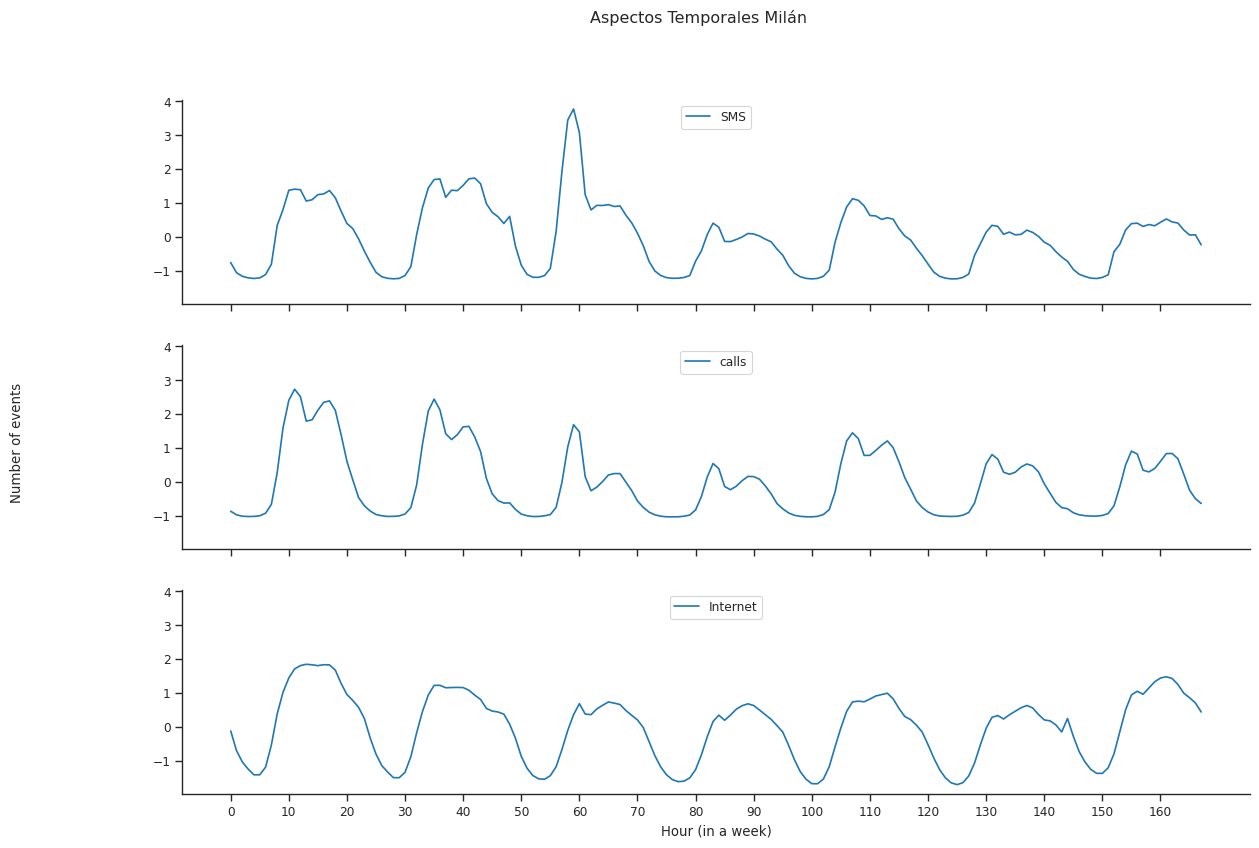

In [14]:
# Group by weekday-hour
sliceSum_city = sliceSum.groupby(['weekday', 'hour'], as_index=False).sum()
sliceSum_city['sms'] = sliceSum_city['smsin'] + sliceSum_city['smsout']
sliceSum_city['calls'] = sliceSum_city['callin'] + sliceSum_city['callout']
sliceSum_city.rename(columns={'sms': 'SMS', 'internet': 'Internet'}, inplace=True)

# Behaviour plot
factor = golden_mean*2
types = ['SMS', 'calls', 'Internet'] 
fig_size2 = [fig_width*factor**5, fig_width * factor**3]
f, axs = plt.subplots(len(types), sharex=True, sharey=True,figsize=fig_size2)

# Z-score
sliceSum_z = (sliceSum_city - sliceSum_city.mean()) / sliceSum_city.std()

for i, p in enumerate(types):
    plt.xticks(np.arange(168, step=10))
    axs[i].plot(sliceSum_z[p], label=p) 
    axs[i].legend(loc='upper center')
    sns.despine()

f.text(0, 0.5, "Number of events", rotation="vertical", va="center")

plt.xlabel("Hour (in a week)")
plt.suptitle('Aspectos Temporales Milán')
plt.savefig('./Resultados/behaviour.jpg', format='jpg', dpi=330,bbox_inches='tight')
plt.show()

#### <span style='color:DarkBlue'> **Resultados Aspectos Temporales**</span>

En la gráfica anterior se muestran la evolución temporal de los datos de actividad en los campos SMS (smsin + smsout), Calls (callin + callout) e Internet para la semana del Lunes 22/12/2013 al Domingo 28/12/2013. 

Esta gráfica nos **permite intuir el comportamiento de los ciudadanos de Milán durante la semana de Navidad**. Centrándonos en el día 24/12/2013 (Nochebuena) y del día 25/12/2013 (Navidad), podemos observar un **pico de actividad en los campos SMS y Calls en las primeras horas del día 24 para, posteriormente, disminuir significativamente la actividad** en comparación al resto de días. Este comportamiento es, a mi parecer, curioso para las fechas que son. En cambio he encontrado la siguiente explicación lógica:

- **En la mañana del 24, los milaneses están realizando los últimos preparativos para la cena de Nochebuena** $\Rightarrow$ Realizan muchas llamadas y envían muchos mensajes. 

- A partir de este momento, **los milaneses se reunen con sus familias, por lo que ya no necesitan realizar llamadas o enviar SMS**, por lo que estos campos reducen significativamente su actividad en estos dos días. La actividad presente en estas horas puede deberse a los comercios abiertos a lo largo de estos días.

El acceso a internet se mantiene similar todos los días, pues para (prácticamente) todas las acciones telefónicas se requiere acceso a internet.

---

Ahora pasamos a analizar los **aspectos espaciales** de las celdas:

- **Bocconi (4259)**
- **Navigli (4456)**
- **Duomo (5060)**
- **Terreno Agrícola (1419)**
- **Área Industrial (2436)**
- **Areopuerto de Linate (4990)**
- **Residencial Aislado (945)**
- **Residencial Céntrico (5048)**

<div align="center">
    <img src="./Grid_Milan/Celdas_8.png" width="1000">
</div>


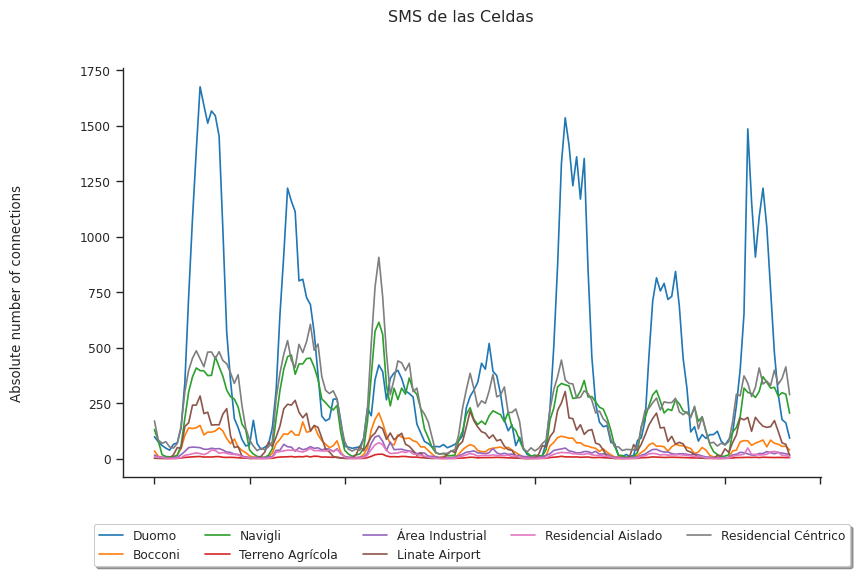

In [38]:
# # Validation behavioural plots

# Gráfico de SMS (smsin + smsout)
DUOMO = sliceSum[sliceSum.CellID == 5060].set_index('idx').sort_index()['smsin'] + sliceSum[sliceSum.CellID == 5060].set_index('idx').sort_index()['smsout']
BOCCONI = sliceSum[sliceSum.CellID ==  4259].set_index('idx').sort_index()['smsin'] + sliceSum[sliceSum.CellID ==  4259].set_index('idx').sort_index()['smsout']
NAVIGLI = sliceSum[sliceSum.CellID == 4456].set_index('idx').sort_index()['smsin'] + sliceSum[sliceSum.CellID == 4456].set_index('idx').sort_index()['smsout']
AGRICOLA = sliceSum[sliceSum.CellID == 1419].set_index('idx').sort_index()['smsin'] + sliceSum[sliceSum.CellID == 1419].set_index('idx').sort_index()['smsout']
INDUSTRIAL = sliceSum[sliceSum.CellID == 2436].set_index('idx').sort_index()['smsin'] + sliceSum[sliceSum.CellID == 2436].set_index('idx').sort_index()['smsout']
LINATE = sliceSum[sliceSum.CellID == 4990].set_index('idx').sort_index()['smsin'] + sliceSum[sliceSum.CellID == 4990].set_index('idx').sort_index()['smsout']
AISLADO = sliceSum[sliceSum.CellID == 945].set_index('idx').sort_index()['smsin'] + sliceSum[sliceSum.CellID == 945].set_index('idx').sort_index()['smsout']
CENTRICO = sliceSum[sliceSum.CellID == 5048].set_index('idx').sort_index()['smsin'] + sliceSum[sliceSum.CellID == 5048].set_index('idx').sort_index()['smsout']

fig_size2 = [fig_width*factor**3,fig_width*factor**1 ]
f, axs = plt.subplots(1, sharex=True, sharey=False, figsize=fig_size2);
axs.plot(DUOMO, label='Duomo')
axs.plot(BOCCONI, label='Bocconi')
axs.plot(NAVIGLI, label='Navigli')
axs.plot(AGRICOLA, label='Terreno Agrícola')
axs.plot(INDUSTRIAL, label='Área Industrial')
axs.plot(LINATE, label='Linate Airport')
axs.plot(AISLADO, label='Residencial Aislado')
axs.plot(CENTRICO, label='Residencial Céntrico')
axs.set_xticklabels([])
sns.despine();
box = axs.get_position()
axs.set_position([box.x0, box.y0 + box.height * 0.1, box.width, box.height * 0.9])
axs.legend(loc='upper center', bbox_to_anchor=(0.5, -0.10), fancybox=True, shadow=True, ncol=5)

plt.suptitle('SMS de las Celdas')
f.text(0, 0.5, "Absolute number of connections", rotation="vertical", va="center")
plt.savefig('./Resultados/SMS_Milano.jpg', format='jpg', dpi=330, bbox_inches='tight')
plt.show()

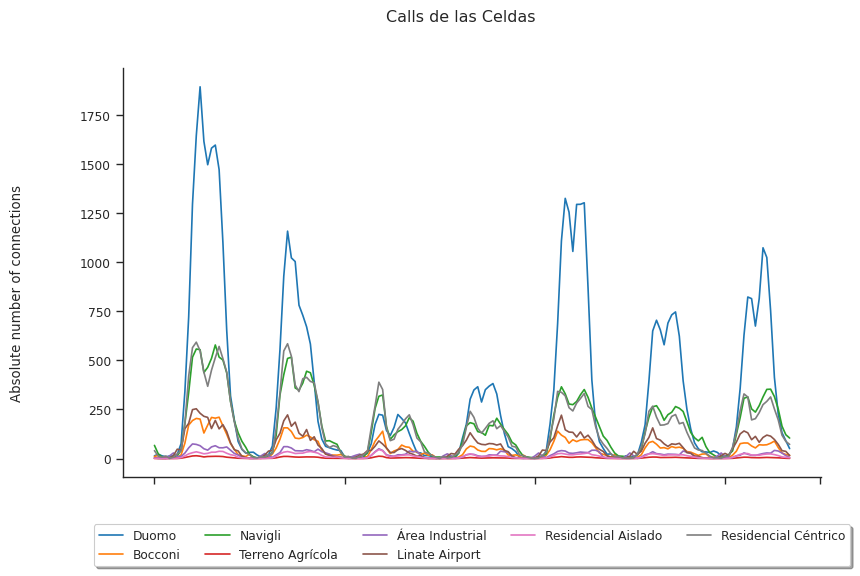

In [39]:
# Gráfico de Calls (callin + callout)
DUOMO = sliceSum[sliceSum.CellID == 5060].set_index('idx').sort_index()['callin'] + sliceSum[sliceSum.CellID == 5060].set_index('idx').sort_index()['callout']
BOCCONI = sliceSum[sliceSum.CellID ==  4259].set_index('idx').sort_index()['callin'] + sliceSum[sliceSum.CellID ==  4259].set_index('idx').sort_index()['callout']
NAVIGLI = sliceSum[sliceSum.CellID == 4456].set_index('idx').sort_index()['callin'] + sliceSum[sliceSum.CellID == 4456].set_index('idx').sort_index()['callout']
AGRICOLA = sliceSum[sliceSum.CellID == 1419].set_index('idx').sort_index()['callin'] + sliceSum[sliceSum.CellID == 1419].set_index('idx').sort_index()['callout']
INDUSTRIAL = sliceSum[sliceSum.CellID == 2436].set_index('idx').sort_index()['callin'] + sliceSum[sliceSum.CellID == 2436].set_index('idx').sort_index()['callout']
LINATE = sliceSum[sliceSum.CellID == 4990].set_index('idx').sort_index()['callin'] + sliceSum[sliceSum.CellID == 4990].set_index('idx').sort_index()['callout']
AISLADO = sliceSum[sliceSum.CellID == 945].set_index('idx').sort_index()['callin'] + sliceSum[sliceSum.CellID == 945].set_index('idx').sort_index()['callout']
CENTRICO = sliceSum[sliceSum.CellID == 5048].set_index('idx').sort_index()['callin'] + sliceSum[sliceSum.CellID == 5048].set_index('idx').sort_index()['callout']

fig_size2 = [fig_width*factor**3,fig_width*factor**1 ]
f, axs = plt.subplots(1, sharex=True, sharey=False, figsize=fig_size2);
axs.plot(DUOMO, label='Duomo')
axs.plot(BOCCONI, label='Bocconi')
axs.plot(NAVIGLI, label='Navigli')
axs.plot(AGRICOLA, label='Terreno Agrícola')
axs.plot(INDUSTRIAL, label='Área Industrial')
axs.plot(LINATE, label='Linate Airport')
axs.plot(AISLADO, label='Residencial Aislado')
axs.plot(CENTRICO, label='Residencial Céntrico')
axs.set_xticklabels([])
sns.despine();
box = axs.get_position()
axs.set_position([box.x0, box.y0 + box.height * 0.1, box.width, box.height * 0.9])
axs.legend(loc='upper center', bbox_to_anchor=(0.5, -0.10), fancybox=True, shadow=True, ncol=5)

plt.suptitle('Calls de las Celdas')
f.text(0, 0.5, "Absolute number of connections", rotation="vertical", va="center")
plt.savefig('./Resultados/Calls_Milano.jpg', format='jpg', dpi=330, bbox_inches='tight')
plt.show()

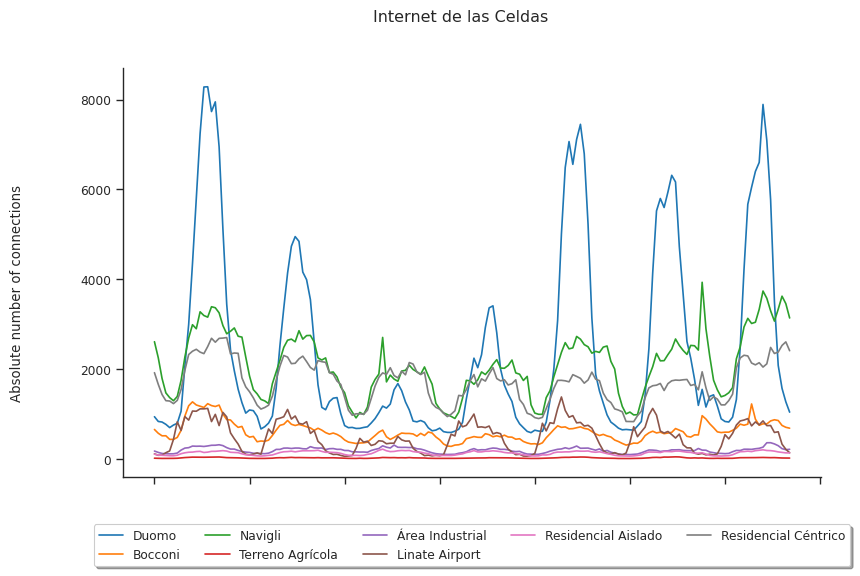

In [40]:
# Gráfico de Internet

fig_size2 = [fig_width*factor**3,fig_width*factor**1 ]

f, axs = plt.subplots(1, sharex=True, sharey=False, figsize=fig_size2);

axs.plot(sliceSum[sliceSum.CellID == 5060].set_index('idx').sort_index()['internet'], label='Duomo')
axs.plot(sliceSum[sliceSum.CellID == 4259].set_index('idx').sort_index()['internet'], label='Bocconi')
axs.plot(sliceSum[sliceSum.CellID == 4456].set_index('idx').sort_index()['internet'], label='Navigli')
axs.plot(sliceSum[sliceSum.CellID == 1419].set_index('idx').sort_index()['internet'], label='Terreno Agrícola')
axs.plot(sliceSum[sliceSum.CellID == 2436].set_index('idx').sort_index()['internet'], label='Área Industrial')
axs.plot(sliceSum[sliceSum.CellID == 4990].set_index('idx').sort_index()['internet'], label='Linate Airport')
axs.plot(sliceSum[sliceSum.CellID == 945].set_index('idx').sort_index()['internet'], label='Residencial Aislado')
axs.plot(sliceSum[sliceSum.CellID == 5048].set_index('idx').sort_index()['internet'], label='Residencial Céntrico')
axs.set_xticklabels([])
sns.despine();
box = axs.get_position()
axs.set_position([box.x0, box.y0 + box.height * 0.1, box.width, box.height * 0.9])
axs.legend(loc='upper center', bbox_to_anchor=(0.5, -0.10), fancybox=True, shadow=True, ncol=5)

plt.suptitle('Internet de las Celdas')
f.text(0, 0.5, "Absolute number of connections", rotation="vertical", va="center")
plt.savefig('./Resultados/Internet_Milano.jpg', format='jpg', dpi=330, bbox_inches='tight')
plt.show()

#### <span style='color:DarkBlue'> **Resultados Aspectos Espaciales**</span>

Como se puede comprobar en las gráficas anteriores , **se verifica el comportamiento temporal descrito anteriormente**. Además, como es lógico **la actividad de las zonas rurales es muy inferior en comparación a las zonas dentro de Milán**. 

Por otro lado, **el aeropuerto de Linate disminuye su actividad el día 24/12/2013 (Nochebuena)**, puesto que es día festivo y las familias ya se habrán reunido. En cambio **el día 25/12/2013 se restablece su actividad** ya que las familias regresan a sus respectivos hogares.

---